In [1]:
import sys
sys.path.append('src')

In [4]:

from energiapy.components.result import Result
import pandas
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results, calculate_hourly
from energiapy.components.transport import Transport
from energiapy.components.scenario import Scenario
from energiapy.components.network import Network
from energiapy.components.location import Location
from energiapy.components.material import Material
from energiapy.components.case_study import CaseStudy
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.temporal_scale import TemporalScale
import numpy
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit


In [7]:
coord_houston = (29.56999969482422, -95.05999755859375)
weather_houston = pandas.read_csv('weather_houston.csv', index_col=0)
weather_houston.index = pandas.to_datetime(weather_houston.index, utc = True)

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_15408\2559363786.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_houston.index = pandas.to_datetime(weather_houston.index, utc = True)


In [8]:
solar_houston = solar_power_output(data= weather_houston, coord=coord_houston, sam = 'cecmod', module_params= 'Canadian_Solar_Inc__CS5P_220M', 
                                   inverter = 'cecinverter', inverter_params= 'ABB__MICRO_0_25_I_OUTD_US_208__208V_', 
                                   temperature_params= 'open_rack_glass_glass', aoi_model= 'no_loss', ac_model= 'sandia', spectral_model= 'no_loss')

In [9]:
wind_houston = wind_power_output(data= weather_houston, roughness_length= 0.1, turbine_type= 'V100/1800', hub_height= 92, 
                                 wind_speed_model= 'logarithmic', density_model = 'ideal_gas', temperature_model = 'linear_gradient', 
                                 power_output_model = 'power_coefficient_curve', density_correction = True, obstacle_height = 0, 
                                 observation_height = 10)

### Natural gas prices

Natural gas prices are from the Henry price index at a daily temporal resolution.

The energia.make_henry_price_df function implicitly fills in gaps in data such as weekends and public holidays by repeating the last recorded prices For e.g. if the 4th of July will use the price for the 3rd of July a typical saturday and sunday will take the values for the last friday.

The stretch functionality stretches the values over the hourly temporal scale (8760) from a daily temporal scale (365), again through repetition.

Moreover, we can remove outliers usig the remove_outliers features in data_utils

In [11]:
ng_price_df = pandas.concat(
    [make_henry_price_df(file_name='Henry_Hub_Natural_Gas_Spot_Price_Daily.csv', year=2016 +i, stretch= True) for i in range(5)]) #, 

### Demand data

Get [hourly power demand data](https://www.ercot.com/gridinfo/load/load_hist)  for Houston from ERCOT Coastal region

In [12]:
ercot = pandas.read_csv('ercot.csv', index_col=0)
ercot.index = pandas.to_datetime(ercot.index, utc = True)
ercot.loc['2016-11-06 23:00:00'] = ercot.loc['2016-11-06 22:00:00'] #random missing value

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_15408\2618497395.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ercot.index = pandas.to_datetime(ercot.index, utc = True)


In [13]:
df_wind_ho = wind_houston
df_solar_ho = solar_houston

In [14]:
df_load_ho = ercot
# df_load_ho.head (5)

In [15]:
df_natgas_price = ng_price_df

In [16]:
scales = TemporalScale(discretization_list=[1, 365, 24])

In [17]:
bigM = 10**6
smallM = 0

In [18]:
Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max= bigM, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand = True, label='Power generated', varying = [VaryingResource.DETERMINISTIC_DEMAND])

H2 = Resource(name='H2', basis='tons', label='Hydrogen',  block='Resource')

H2_FC = Resource(name='H2_FC', basis='tons', label='Hydrogen_to_FC',  block='Resource')

H2_L = Resource(name='H2_L', basis='tons', label='Liquid Hydrogen', block='Resource', store_max = 10000)

CO2_AQoff = Resource(name='CO2_AQoff', basis='kg', label='Carbon dioxide - sequestered', store_max = 10000)

H2O = Resource(name='H2O', cons_max=bigM**2, price= 0.001, basis='tons', label='Water', block='Resource')

CH4 = Resource(name='CH4', cons_max=bigM**2, price=1, basis='tons', label='Natural gas', varying=  [VaryingResource.DETERMINISTIC_PRICE])

CO2 = Resource(name='CO2', basis='tons', label='Carbon dioxide', block='Resource')

CO2_Vent = Resource(name='CO2_Vent', sell=True, basis='tons', label='Carbon dioxide - Vented')

O2 = Resource(name='O2', sell=True, basis='tons', label='Oxygen')

# PowerSMR = Resource(name='PowerSMR', basis='MW', price = 1 , label='Power Consumed', varying = [VaryingResource.DETERMINISTIC_PRICE]*0.25)

#CO2_DAC = Resource(name='CO2_DAC', basis='kg', label='Carbon dioxide - captured')

In [19]:
LiI = Process(name='LiI', storage= Power, store_max = 120000, capex = (2956000), fopex= 10000, vopex = 0,  prod_max=bigM, label='Lithium-ion battery', basis = 'MW')

OffWF = Process(name='OWF', conversion={Wind: -1, Power: 1},capex= (1233000), fopex=40000, vopex=0, prod_max=bigM, label='Offshore Wind mill array', varying= [VaryingProcess.DETERMINISTIC_CAPACITY], basis = 'MW')

LandWF = Process(name='LWF', conversion={Wind: -1, Power: 1},capex= (2644000), fopex=66000, vopex=0, prod_max=bigM, label='Landfarm Wind mill array', varying= [VaryingProcess.DETERMINISTIC_CAPACITY], basis = 'MW')

UtilityPV = Process(name='UPV', conversion={Solar: -1, Power: 1}, capex=(1333260), fopex=22600, vopex=0, prod_max=120000, varying = [VaryingProcess.DETERMINISTIC_CAPACITY], label = 'Solar UPV', basis = 'MW', land = 10000/1800)

ResidentialPV  = Process(name='RPV', conversion={Solar: -1, Power: 1}, capex=(2743000), fopex=29295, vopex=0, prod_max=120000, varying = [VaryingProcess.DETERMINISTIC_CAPACITY], label = 'Solar RPV', basis = 'MW')

SMRH = Process(name='SMRH', conversion={Power: -5.2, CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 9.4979}, capex =2520, fopex = 945, vopex = 0.0515, prod_max= 10000, label='Steam methane reforming + CCUS')

PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, O2: 2.8302, H2O: -3.1839}, capex=1.55*10**6, fopex=0,
              vopex=0, prod_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )
# SMR = Process(name='SMR', capex = 2400, fopex = 800, vopex = 0.03,  conversion={CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 9.4979}, prod_max=bigM, label='Steam methane reforming')

H2FC = Process(name='H2FC', conversion = {H2_FC:-0.11, Power: 1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max = 10000, label = 'hydrogen fuel cell')

# DAC = Process(name='DAC', capex = 0.02536, fopex = 0.634, vopex = 0, conversion={Power: -1.93*10**(-4), H2O: -4.048, CO2_DAC: 1}, prod_max=bigM, label='Direct air capture')

H2_L_c = Process(name='H2_L_c', conversion={Power: -4.17*10**(-1), H2_L: 1, H2: -1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max= 10000, label='Hydrogen geological storage')

H2_L_d = Process(name='H2_L_d', conversion={H2_L: -1, H2_FC: 1}, capex =  0.01, vopex = 0.001, fopex = 0, prod_max= bigM, label='Hydrogen geological storage discharge')

#AQoff_SMR = Process(name='AQoff_SMR', conversion={Power: -0.00128, CO2_AQoff: 1, CO2: -1}, capex =  0.00552, vopex = 0.00414, fopex = 0, prod_max= bigM,  label='Offshore aquifer CO2 sequestration (SMR)')

In [58]:
houston = Location(name='houston',
                   processes= { UtilityPV
                               #, OffWF
                               #, LandWF
                               , LiI
                               , ResidentialPV
                            #    , PEM
                            #    , H2FC
                            #    , H2_L_c
                            #    , H2_L_d
                               #, AQoff_SMR
                               },
                   capacity_factor = {UtilityPV: df_solar_ho[8760*4:],
                                      ResidentialPV: df_solar_ho[8760*4:],
                                      OffWF :df_wind_ho[8760*4:],
                                      LandWF:df_wind_ho[8760*4:]
                                      },
                   demand_factor= {Power: df_load_ho[8760*4:]},
                   price_factor = {CH4: df_natgas_price[8760*4:]},
                   scales=scales, label='Houston',
                   demand_scale_level=2,
                   capacity_scale_level= 2,
                   price_scale_level= 2,
                   land_cost = 2100)

In [59]:
case = Scenario(name= 'case', network= houston, network_scale_level= 0, purchase_scale_level = 2, demand_scale_level = 2, scheduling_scale_level= 2, capacity_scale_level = 2, scales= scales,  demand = {houston: {Power: 100}}, label= 'houston transition 2.4M', annualization_factor= 1/30)

In [60]:
milp = formulate(scenario= case, constraints={Constraints.COST,
                                              Constraints.INVENTORY,
                                              Constraints.PRODUCTION,
                                              Constraints.RESOURCE_BALANCE,
                                              Constraints.NETWORK,
                                              Constraints.DEMAND,
                                              Constraints.LAND},
                 objective=Objective.COST, inventory_zero = {houston: {(LiI, Power): 800}})

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint land process
constraint land location
constraint land network
constraint land process cost
constraint land location cost
constraint land network cost
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [61]:
results = solve(scenario= case, instance = milp, solver = 'gurobi', name = 'base', print_solversteps = True, saveformat = '.pkl')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131469 rows, 113947 columns and 350482 nonzeros
Model fingerprint: 0xd88138e2
Variable types: 113942 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118035 rows and 100509 columns
Presolve time: 0.22s
Presolved: 13434 rows, 13438 columns, 44302 nonzeros
Variable types: 13438 continuous, 0 integer (0 binary)

Root relaxation: objective 2.063969e+08, 5507 iterations, 0.15 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

In [64]:
results.output['Cap_P']

{('houston', 'LiI', 0): 278.565975953652,
 ('houston', 'LiI_discharge', 0): 1000000.0,
 ('houston', 'RPV', 0): 0.0,
 ('houston', 'UPV', 0): 2238.1678043758484}

In [62]:
results.output['Land_location']

{('houston', 0): 12434.265579865823}

In [65]:
2238*5.55

12420.9

: 

In [ ]:
12434

In [23]:
# plot_location.capacity_factor(process=UtilityPV, location=houston)
# # plot_location.capacity_factor(process=WF, location=houston)
# plot_location.price_factor(resource=CH4, location=houston)
# plot_location.demand_factor(resource=Power, location=houston)

In [24]:
range_ = 20

In [63]:
locations = {i: Location(name='houston',
                   processes= { UtilityPV
                               #, OffWF
                               #, LandWF
                               , LiI
                               , ResidentialPV
                            #    , PEM
                            #    , H2FC
                            #    , H2_L_c
                            #    , H2_L_d
                               #, AQoff_SMR
                               },
                   capacity_factor = {UtilityPV: df_solar_ho[8760*4:],
                                      ResidentialPV: df_solar_ho[8760*4:],
                                      OffWF :df_wind_ho[8760*4:],
                                      LandWF:df_wind_ho[8760*4:]
                                      },
                   demand_factor= {Power: df_load_ho[8760*4:]},
                   price_factor = {CH4: df_natgas_price[8760*4:]},
                   scales=scales, label='Houston',
                   demand_scale_level=2,
                   capacity_scale_level= 2,
                   price_scale_level= 2,
                   land_cost = 1000*i) for i in range(range_)}

In [26]:
case_dict = {i: Scenario(name= 'case', network= locations[i], network_scale_level= 0, purchase_scale_level = 2, demand_scale_level = 2, scheduling_scale_level= 2, capacity_scale_level = 2, scales= scales,  demand = {locations[i]: {Power: 100}}, label= 'houston transition 2.4M', annualization_factor= 1/30)  for i in range(range_)}

In [28]:
# results.output['Land_location']

NameError: name 'results' is not defined

In [29]:
milp_dict = {1/(i+1): formulate(scenario= case, constraints={Constraints.COST,
                                              Constraints.INVENTORY,
                                              Constraints.PRODUCTION,
                                              Constraints.RESOURCE_BALANCE,
                                              Constraints.NETWORK,
                                              Constraints.DEMAND,
                                              Constraints.LAND},
                 objective=Objective.COST, inventory_zero = {houston: {(LiI, Power): 800}}, land_restriction = 12450/(i+1)) for i in range(5)}

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint land process
constraint land location
constraint land network
constraint land process cost
constraint land location cost
constraint land network cost
constraint land location restriction
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint land process
constraint land location
constraint land network
constraint land process cost
constraint land location cost
constraint 

In [30]:
results_la = {1/(i+1): solve(scenario = case, instance= milp_dict[1/(i+1)], solver= 'gurobi', name="results_cost", print_solversteps = True, saveformat = '.pkl') for i in range(5)}

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131470 rows, 113947 columns and 350483 nonzeros
Model fingerprint: 0xe7d6bb09
Variable types: 113942 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118048 rows and 100521 columns
Presolve time: 0.35s
Presolved: 13422 rows, 13426 columns, 44268 nonzeros
Variable types: 13426 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980984e+08, 4450 iterations, 0.12 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131470 rows, 113947 columns and 350483 nonzeros
Model fingerprint: 0xaef0bac0
Variable types: 113942 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118048 rows and 100521 columns
Presolve time: 0.20s
Presolved: 13422 rows, 13426 columns, 44268 nonzeros
Variable types: 13426 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980984e+08, 4450 iterations, 0.10 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131470 rows, 113947 columns and 350483 nonzeros
Model fingerprint: 0x2ffd5174
Variable types: 113942 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118048 rows and 100521 columns
Presolve time: 0.21s
Presolved: 13422 rows, 13426 columns, 44268 nonzeros
Variable types: 13426 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980984e+08, 4450 iterations, 0.13 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131470 rows, 113947 columns and 350483 nonzeros
Model fingerprint: 0xedb2a624
Variable types: 113942 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118048 rows and 100521 columns
Presolve time: 0.22s
Presolved: 13422 rows, 13426 columns, 44268 nonzeros
Variable types: 13426 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980984e+08, 4450 iterations, 0.10 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131470 rows, 113947 columns and 350483 nonzeros
Model fingerprint: 0x16362ebf
Variable types: 113942 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118048 rows and 100521 columns
Presolve time: 0.24s
Presolved: 13422 rows, 13426 columns, 44268 nonzeros
Variable types: 13426 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980984e+08, 4450 iterations, 0.10 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

In [133]:
# milp_dict2 = {i: formulate(scenario= case_dict[i], constraints={Constraints.COST,
#                                               Constraints.INVENTORY,
#                                               Constraints.PRODUCTION,
#                                               Constraints.RESOURCE_BALANCE,
#                                               Constraints.NETWORK,
#                                               Constraints.DEMAND,
#                                               Constraints.LAND},
#                  objective=Objective.COST, inventory_zero = {locations[i]: {(LiI, Power): 800}}) for i in range(range_)}

In [132]:
# results_lc = {i: solve(scenario = case_dict[i], instance= milp_dict2[i], solver= 'gurobi', name="results_cost", print_solversteps = True, saveformat = '.pkl') for i in range(range_)}

In [45]:
results_la[0.2].output['Cap_P']

{('houston', 'LiI', 0): 347.0675683762059,
 ('houston', 'LiI_discharge', 0): 1000000.0,
 ('houston', 'RPV', 0): 2157.156935005291,
 ('houston', 'UPV', 0): 0.0}

In [37]:
results_la[0.5].output['Cap_P']

{('houston', 'LiI', 0): 347.0675683762059,
 ('houston', 'LiI_discharge', 0): 1000000.0,
 ('houston', 'RPV', 0): 2157.156935005291,
 ('houston', 'UPV', 0): 0.0}

In [40]:
2157*5.55

11971.35

In [31]:
results_lc[3].output['S_network']

NameError: name 'results_lc' is not defined

In [108]:
milp = formulate(scenario= case, constraints={Constraints.COST,
                                              Constraints.INVENTORY,
                                              Constraints.PRODUCTION,
                                              Constraints.RESOURCE_BALANCE,
                                              Constraints.NETWORK,
                                              Constraints.DEMAND,
                                              Constraints.LAND},
                 objective=Objective.COST, inventory_zero = {houston: {(LiI, Power): 800}}, land_restriction = 0)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint production mode
constraint land process
constraint land location
constraint land network
constraint land process cost
constraint land location cost
constraint land network cost
constraint land location restriction
constraint inventory balance
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [109]:
# milp_max = formulate(scenario= case, constraints={Constraints.COST,
#                                               Constraints.INVENTORY,
#                                               Constraints.PRODUCTION,
#                                               Constraints.RESOURCE_BALANCE,
#                                               Constraints.NETWORK,
#                                             #   Constraints.DEMAND,
#                                               Constraints.LAND},
#                  objective=Objective.MAX_DISCHARGE, objective_resource = Power)

In [110]:
results = solve(scenario = case, instance= milp, solver= 'gurobi', name="results_cost", print_solversteps = True, saveformat = '.pkl')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131466 rows, 113943 columns and 341717 nonzeros
Model fingerprint: 0xc4bbcaaa
Variable types: 113938 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 1e+06]
Presolve removed 118047 rows and 100521 columns
Presolve time: 0.15s
Presolved: 13419 rows, 13422 columns, 39900 nonzeros
Variable types: 13422 continuous, 0 integer (0 binary)

Root relaxation: objective 2.980984e+08, 5656 iterations, 0.11 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0 

In [111]:
results.output['objective']

298098361.58933735

In [128]:
y = [results_la[1/(i+1)].output['objective'] for i in range(5) ] #+ [results.output['objective']]
x = [1/(i+1) for i in range(5)] #+ [0]


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (6).

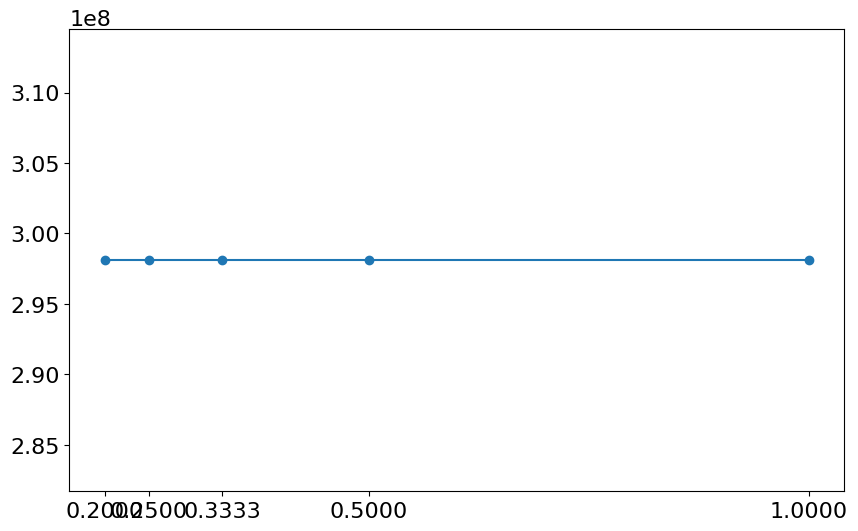

In [129]:
from matplotlib import rc
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(x, y)
ax.scatter(x, y)
ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(['1', '1/2', '1/3', '1/4', '1/5', '0'])
ax.set_xlabel('Fraction of land available')
ax.set_ylabel('Objective Cost ($)')
plt.grid(alpha=0.3)
plt.rcdefaults()



In [121]:
y_rpv = [results_la[1/(i+1)].output['P_network'][('RPV', 0)] for i in range(5)] + [results.output['P_network'][('RPV', 0)]]
y_upv = [results_la[1/(i+1)].output['P_network'][('UPV', 0)] for i in range(5)] +  [results.output['P_network'][('UPV', 0)]]


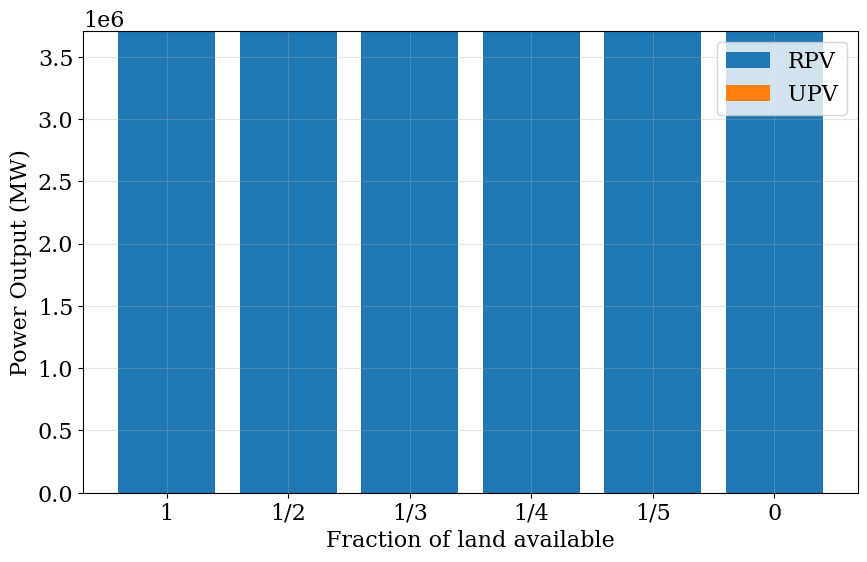

In [122]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(['1', '1/2', '1/3', '1/4', '1/5', '0'], y_rpv, label = 'RPV')
ax.bar(['1', '1/2', '1/3', '1/4', '1/5', '0'], y_upv, bottom = y_rpv, label = 'UPV')
ax.set_xlabel('Fraction of land available')
ax.set_ylabel('Power Output (MW)')
plt.legend()
plt.grid(alpha=0.3)
plt.rcdefaults()

In [ ]:
y = [results_lc[i].output['objective'] for i in range(range_) ] 
x = [500*(i) for i in range(range_)] 

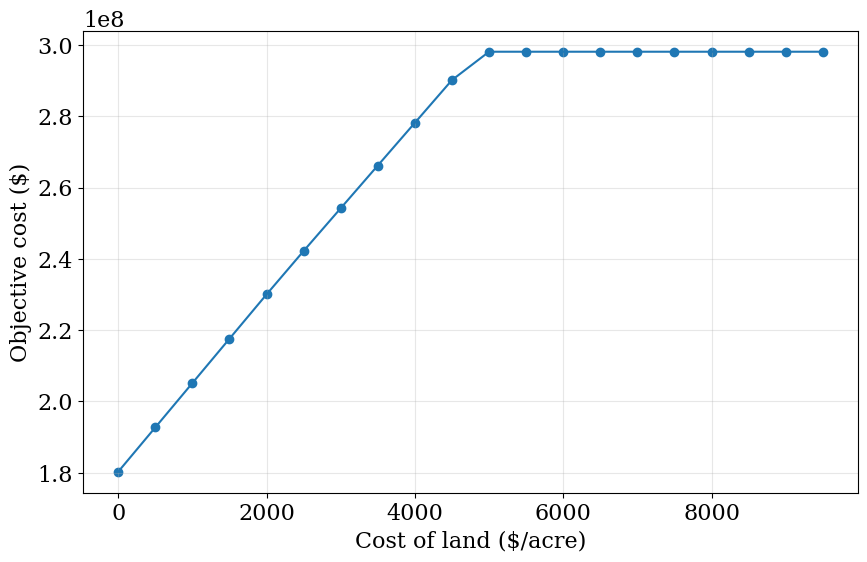

In [ ]:
from matplotlib import rc
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(x, y)
ax.scatter(x, y)
# ax.xaxis.set_ticks(x)
# ax.xaxis.set_ticklabels(['1', '1/2', '1/3', '1/4', '1/5', '0'])
ax.set_xlabel('Cost of land ($/acre)')
ax.set_ylabel('Objective cost ($)')
plt.grid(alpha=0.3)
plt.rcdefaults()


In [ ]:
y_rpv = [results_lc[i].output['P_network'][('RPV', 0)] for i in range(range_)] 
y_upv = [results_lc[i].output['P_network'][('UPV', 0)] for i in range(range_)] 

In [ ]:
y_rpv

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535,
 3708143.6646049535]

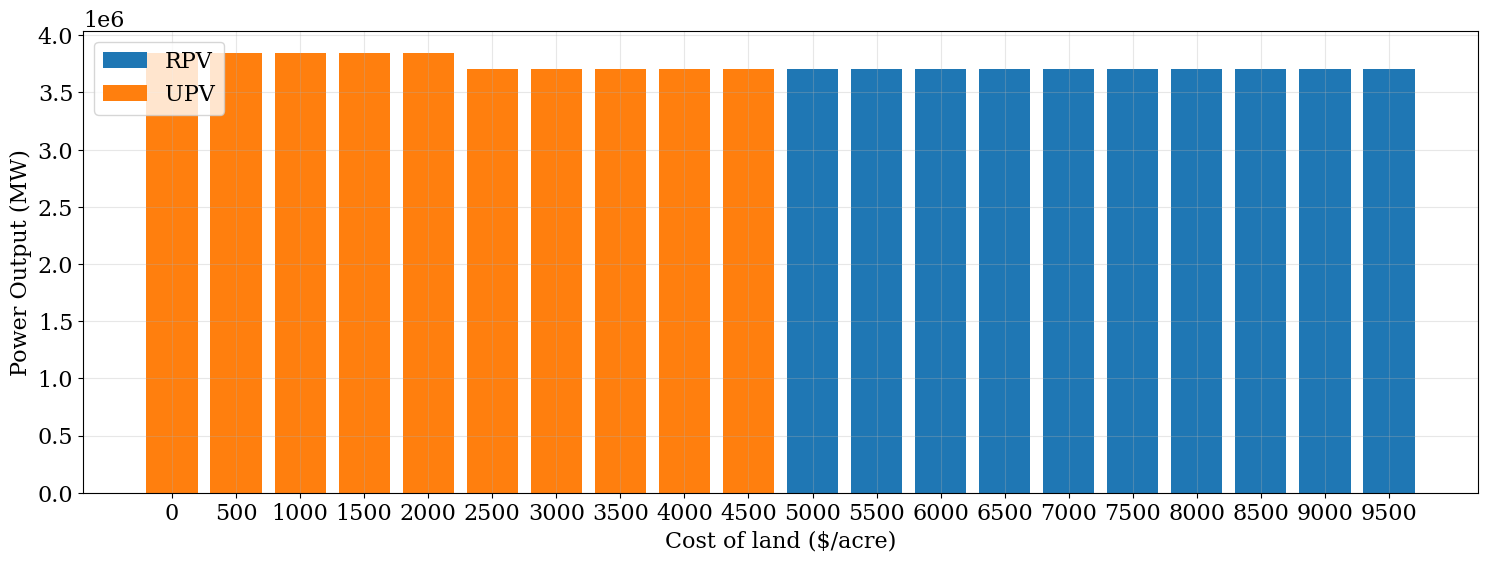

In [ ]:
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (18, 6))
ax.bar([str(i) for i in x] , y_rpv, label = 'RPV')
ax.bar([str(i) for i in x] , y_upv, bottom = y_rpv, label = 'UPV')
ax.set_ylabel('Power Output (MW)')
ax.set_xlabel('Cost of land ($/acre)')
plt.legend()
plt.grid(alpha=0.3)
plt.rcdefaults()

In [ ]:
results.output['Land_network']

In [ ]:
results.output.keys()

In [ ]:
results.output['Capex_process']

In [ ]:
plot_results.schedule(results= results, y_axis= 'Inv', component= 'LiI_Power_stored', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
plot_results.cost(results=results, x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='houston', fig_size=(11, 6))

In [ ]:
plot_results.cost(results=results, x=CostX.PROCESS_WISE,
                  y=CostY.VOPEX, location='houston', fig_size=(11, 6))

In [ ]:
plot_results.cost(results=results, x=CostX.PROCESS_WISE,
                  y=CostY.CAPEX, location='houston', fig_size=(11, 6))

In [ ]:
results.output['objective']

In [ ]:
plot_results.schedule(results= results, y_axis= 'P', component= 'UPV', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
plot_results.schedule(results= results, y_axis= 'P', component= 'RPV', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
#plot_results.schedule(results= results, y_axis= 'P', component= 'LWF', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
#plot_results.schedule(results= results, y_axis= 'P', component= 'OWF', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
plot_results.schedule(results= results, y_axis= 'P', component= 'SMRH', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
plot_results.schedule(results= results, y_axis= 'P', component= 'H2_L_c', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
#LiI.__dict__

In [ ]:
plot_results.schedule(results= results, y_axis= 'Inv', component= 'H2_L', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [ ]:
plot_scenario.demand_factor(
    scenario=case, location=houston, resource=Power, fig_size=(9, 5), color='red')

In [ ]:
plot_scenario.capacity_factor(
    scenario=case, location=houston, process=UtilityPV, fig_size=(9, 5), color='red')

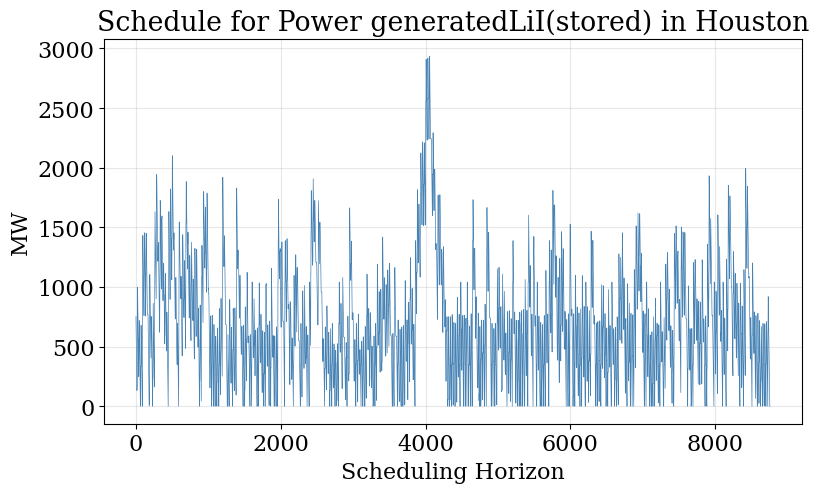

In [ ]:
plot_results.schedule(results= results, y_axis= 'Inv', component= 'LiI_Power_stored', location = 'houston', fig_size= (9,5), color = 'steelblue')

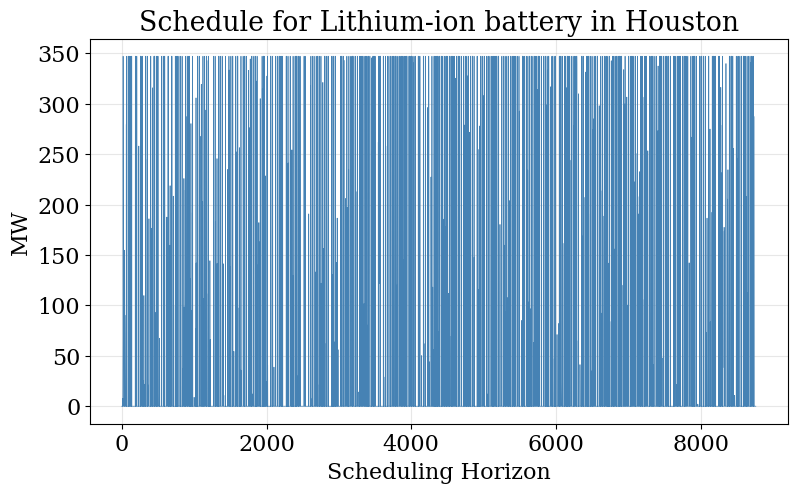

In [ ]:
plot_results.schedule(results= results, y_axis= 'P', component= 'LiI', location = 'houston', fig_size= (9,5), color = 'steelblue')

In [115]:
results_la

{1.0: results_cost, 0.5: results_cost, 0.3333333333333333: results_cost}

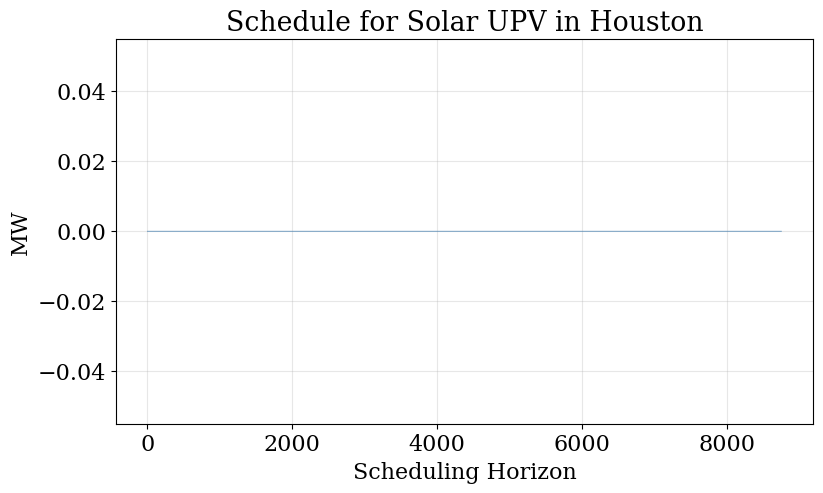

In [130]:
plot_results.schedule(results= results_la[1/2], y_axis= 'P', component= 'UPV', location = 'houston', fig_size= (9,5), color = 'steelblue')

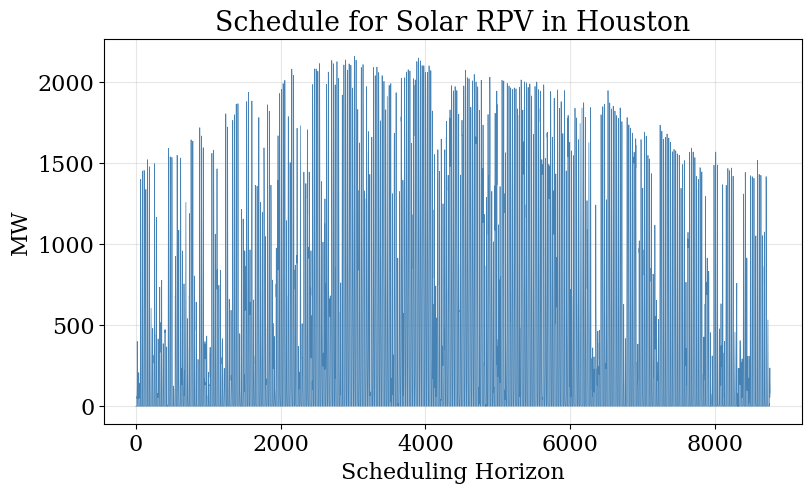

In [131]:
plot_results.schedule(results= results_la[1/3], y_axis= 'P', component= 'RPV', location = 'houston', fig_size= (9,5), color = 'steelblue')